# Gaussian Mixture Models (GMM) — From Scratch + Comparison with k-means + Digits Generation

This notebook combines:
- **MML-book GMM tutorial & solution** — theoretical EM derivation and from-scratch implementation
- **Python Data Science Handbook** (Jake VanderPlas) — visual exploration, k-means vs GMM comparison, and generative modeling

We will:
1. Implement GMM using EM algorithm **from scratch**
2. Fit it to a **non-spherical 2D dataset** for better visualization
3. Compare to **k-means**
4. Apply GMMs for **digit clustering and generation**


## Learning goals
After this tutorial you should be able to:
- Understand the EM algorithm for Gaussian Mixture Models
- Implement E-step and M-step manually
- Visualize how GMM generalizes k-means
- Use GMM to model digits as a generative model


In [1]:
# PACKAGE: DO NOT EDIT
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_digits
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

plt.rcParams['figure.figsize'] = (6, 4)


## 1. Synthetic 2D Dataset with Non-Spherical Clusters

We'll create a toy dataset and apply a random linear transformation to make clusters **elongated and rotated**.  
This helps visualize the difference between **k-means** (spherical clusters) and **GMM** (elliptical clusters).


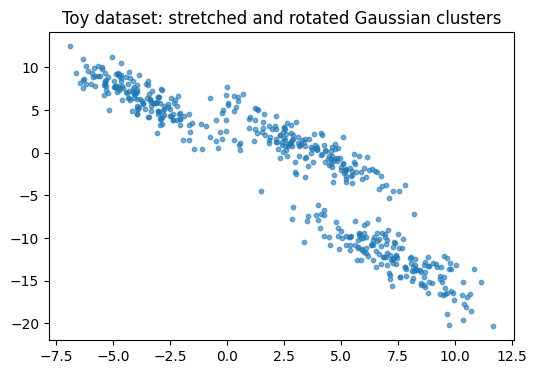

In [2]:
# Create isotropic blobs
rng = np.random.default_rng(13)
X, y_true = make_blobs(
    n_samples=500,
    centers=[(-2, 0), (0, 4), (4, 0)],
    cluster_std=[0.8, 0.9, 1.0],
    random_state=0
)

# Stretch and rotate using random matrix
X_stretched = np.dot(X, rng.standard_normal((2, 2)))

plt.scatter(X_stretched[:, 0], X_stretched[:, 1], s=10, alpha=0.6)
plt.title("Toy dataset: stretched and rotated Gaussian clusters")
plt.show()


In [3]:
def init_gmm_params(X, n_components, random_state=0):
    """Initialize means, covariances, and weights."""

    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape
    means = X[rng.choice(n_samples, n_components, replace=False)]
    covs = np.array([np.eye(n_features) for _ in range(n_components)])
    pi = np.ones(n_components) / n_components
    return pi, means, covs

In [4]:
def log_gaussian_pdf(X, mean, cov):
    """Compute log N(x|mean,cov) for each x."""

    n_samples, n_features = X.shape
    centered = X - mean
    sign, logdet = np.linalg.slogdet(cov)
    inv_cov = np.linalg.inv(cov)
    quad_form = np.sum(centered @ inv_cov * centered, axis=1)
    return -0.5 * (n_features * np.log(2 * np.pi) + logdet + quad_form)

In [5]:
def e_step(X, pi, means, covs):
    """E-step: compute responsibilities gamma_{nk}."""

    n_samples, n_components = X.shape[0], len(pi)
    log_prob = np.array([
        np.log(pi[k]) + log_gaussian_pdf(X, means[k], covs[k])
        for k in range(n_components)
    ])
    log_prob = log_prob.T
    log_sum = np.logaddexp.reduce(log_prob, axis=1, keepdims=True)
    log_resp = log_prob - log_sum
    return np.exp(log_resp)

In [6]:
def m_step(X, gamma, reg_covar=1e-6):
    """M-step: update pi, means, and covariances."""

    n_samples, n_features = X.shape
    nk = gamma.sum(axis=0)
    pi = nk / n_samples
    means = (gamma.T @ X) / nk[:, np.newaxis]
    covs = []
    for k in range(len(pi)):
        diff = X - means[k]
        weighted = gamma[:, k][:, np.newaxis] * diff
        cov_k = (weighted.T @ diff) / nk[k]
        cov_k += reg_covar * np.eye(n_features)
        covs.append(cov_k)
    return pi, means, np.array(covs)

In [7]:
def gmm_em(X, n_components, max_iter=100, tol=1e-4, random_state=0):
    """Run EM algorithm for GMM."""

    pi, means, covs = init_gmm_params(X, n_components, random_state)
    log_likelihoods = []
    for i in range(max_iter):
        gamma = e_step(X, pi, means, covs)
        pi, means, covs = m_step(X, gamma)
        ll = np.sum(np.log(np.sum([
            pi[k] * np.exp(log_gaussian_pdf(X, means[k], covs[k]))
            for k in range(n_components)
        ], axis=0)))
        log_likelihoods.append(ll)
        if i > 0 and abs(ll - log_likelihoods[-2]) < tol:
            break
    return pi, means, covs, log_likelihoods

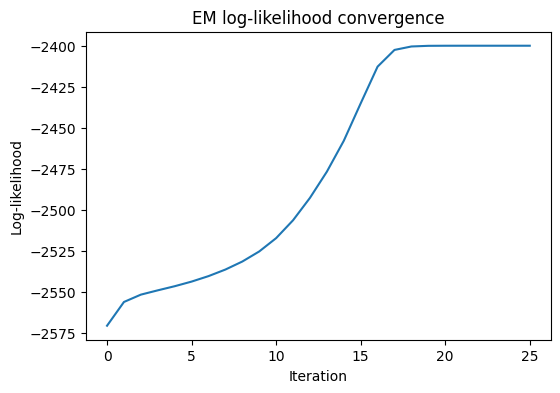

In [8]:
# Fit your GMM from scratch on the stretched dataset
K = 3
pi_hat, means_hat, covs_hat, ll = gmm_em(X_stretched, n_components=K, random_state=0)

plt.plot(ll)
plt.title("EM log-likelihood convergence")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.show()


## 2. Compare GMM vs k-means

Use your GMM implementation and sklearn's k-means to see how they differ on the **stretched data**.


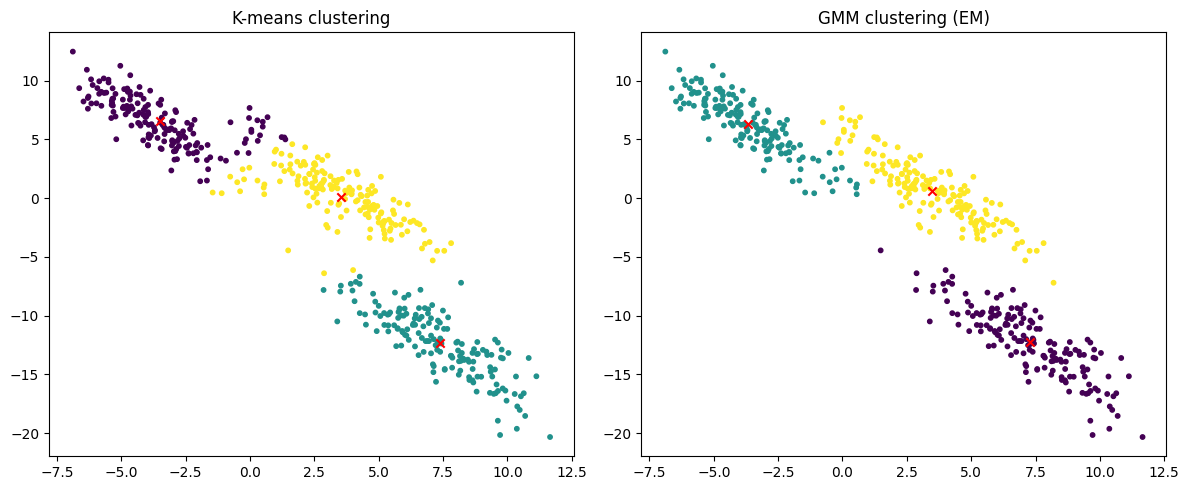

In [9]:
# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
labels_kmeans = kmeans.fit_predict(X_stretched)

# Fit your GMM from scratch
K = 3
pi_hat, means_hat, covs_hat, ll = gmm_em(X_stretched, n_components=K, random_state=0)
gamma = e_step(X_stretched, pi_hat, means_hat, covs_hat)
labels_gmm = np.argmax(gamma, axis=1)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# KMeans plot
axs[0].scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels_kmeans, s=10, cmap='viridis')
axs[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
axs[0].set_title("K-means clustering")

# GMM plot
axs[1].scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels_gmm, s=10, cmap='viridis')
axs[1].scatter(means_hat[:, 0], means_hat[:, 1], c='red', marker='x')
axs[1].set_title("GMM clustering (EM)")

plt.tight_layout()
plt.show()

## 3. GMM on Digits Dataset

Now let's move from 2D toy data to a higher-dimensional example.

We'll use the `digits` dataset to:
- fit GMMs to 10 components
- visualize learned component means as prototypical digits
- sample new synthetic digits


In [10]:
digits = load_digits()
X_digits = digits.data
images = digits.images
print("Digits shape:", X_digits.shape)


Digits shape: (1797, 64)


GMM fitted. Converged: True


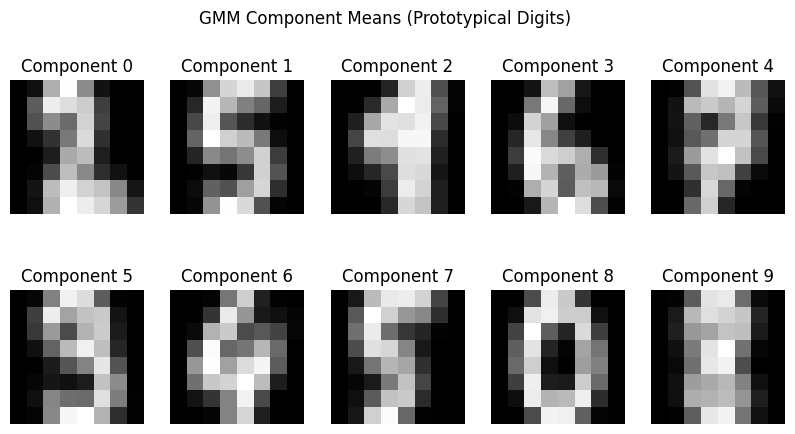

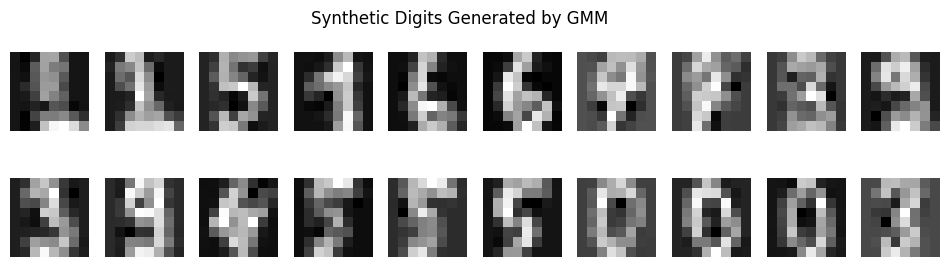

In [11]:
from sklearn.mixture import GaussianMixture

# Fit GMM with 10 components (digits 0–9)
gmm = GaussianMixture(
    n_components=10,
    covariance_type="full",
    random_state=0
)
gmm.fit(X_digits)
print("GMM fitted. Converged:", gmm.converged_)

# Visualize the learned component means
# (each mean is a 64-dim vector = 8×8 image)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    mean_img = gmm.means_[i].reshape(8, 8)
    axes[i].imshow(mean_img, cmap="gray")
    axes[i].set_title(f"Component {i}")
    axes[i].axis("off")

plt.suptitle("GMM Component Means (Prototypical Digits)")
plt.show()



# Generate new synthetic digits
# Sample: z ~ Categorical(pi), x ~ N(mu_z, Sigma_z)

n_samples = 20
samples, _ = gmm.sample(n_samples)

fig, axes = plt.subplots(2, 10, figsize=(12, 3))
axes = axes.ravel()

for i in range(n_samples):
    axes[i].imshow(samples[i].reshape(8, 8), cmap="gray")
    axes[i].axis("off")

plt.suptitle("Synthetic Digits Generated by GMM")
plt.show()

## 4. Reflection

In your own words:
- What is the main difference between k-means and GMM?
- Why does GMM handle elongated clusters better?
- How does GMM act as a **generative** model?


Головна різниця між k-means і GMM: k-means - геометричний алгоритм, GMM - статистична модель розподілу даних.

k-means - алгоритм кластеризації, який:
 - припускає, що кожен кластер є сферичним та має однакову дисперсію;
 - призначає кожну точку до одного кластера;
 - мінімізує суму квадратів відстаней до центрів.

 GMM - ймовірнісна модель, яка:
 - представляє дані сумою гаусових розподілів;
 - дозволяє кожному кластеру мати власну коваріаційну матрицю, тобто форму, кут нахилу і масштаб;
 - виконує м'яке кластеризування через апріорні та апостеріорні ймовірності.


GMM краще працює з витягнутими кластерами, тому що кожен компонент має повну коваріаційну матрицю, яка відображає: дисперсію вздовж різних напрямків, кореляції між ознаками, орієнтацію та форму кластера.

GMM є генеративною моделлю, тому що вона вивчає спільний розподіл ймовірностей
P(X) всього набору даних, а не просто ділить його на групи.
Після навчання модель знає параметри кожного Гауссового компонента(ваги, середні значення, коваріації). Це дозволяє створювати нові дані, яких не було у вибірці, за таким алгоритмом:
- випадковим чином обрати один із кластерів відповідно до їхніх ваг,
- згенерувати зразок із багатовимірного нормального розподілу цього кластера.

У прикладі з цифрами це дозволило створити нові зображення, які досить схожі на оригінал.